In [1]:
import os
import utils
import torch
from models import GAT, SpGAT
import torch.nn.functional as F
import sklearn.metrics
import numpy as np
from torch.autograd import Variable
import pandas as pd
import numpy as np
from data.utils import record_result, mouse_ensg_to_symbol
import random
import scprep
import phate

In [2]:
count_df = pd.read_csv('../../project/CD8_T_count.csv', header=None, index_col=0).T
label_df = pd.read_csv('../../project/CD8_T_label.csv', header=None, index_col=0).T

In [3]:
gene_symbol = mouse_ensg_to_symbol(datastore="../data") # ensembl to symbol
ensembl = dict((v,k) for k,v in gene_symbol.items()) # symbol to ensembl

In [4]:
adj, features, labels, _, _, _, neighbor_genes = utils.load_synthetic_data("Cd8a")
features, adj, labels = Variable(features), Variable(adj), Variable(labels)

 loading from cache file../data/graphs/stringdb_all_mouse_graph_edges.adjlist


In [5]:
model = GAT(ncells = features.shape[0], #features is cells x gene x gene features
                ngenes=features.shape[1], 
                nfeat=features.shape[2],
                nhid=1, 
                nclass=1, # regression
                dropout=0.6, 
                nheads=1, 
                alpha=0.2)

model

GAT(
  (out_att): GraphAttentionLayer (1 -> 1)
)

In [6]:
list(model.parameters()) # optmized in AdamOptimizer

[Parameter containing:
 tensor([[-0.6726]], requires_grad=True),
 Parameter containing:
 tensor([[-0.0587, -0.0846],
         [-0.0015, -0.0127],
         [-0.0041,  0.0080],
         ...,
         [ 0.0332,  0.0021],
         [ 0.0394,  0.1023],
         [-0.0229,  0.0423]], requires_grad=True)]

In [7]:
def loss_fn(output, labels, attention, lam):
    reconstruction = F.smooth_l1_loss(output, labels.float()).float()
    sparsity = lam * (torch.norm(attention, 1) / labels.shape[0])

    return (reconstruction + sparsity)

In [8]:
def compute_test(lam=0.0):
    model.eval()
    output, attention = model(features, adj)

    output = output.reshape(-1)
    loss_test = loss_fn(output[idx_test], labels[idx_test], attention, lam)
    r2_test = sklearn.metrics.r2_score(labels[idx_test].cpu(), output[idx_test].cpu().detach().numpy())
    l0_norm_att_test = sum(~np.isclose(attention[idx_test][0].cpu().detach().numpy().flatten(), np.zeros((attention.cpu().detach().numpy().shape[1])), atol=0.0015))

    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data.item()),
          "r2_test= {:.4f}".format(r2_test),
          "l0_norm_att_test: {}".format(l0_norm_att_test))
    
    return output[idx_test], labels[idx_test], attention[idx_test]

## Without Regularization: best R^2 with lambda = 0.0, learning rate = 0.2, patience = 150

In [11]:
idx_test = np.load('synthetic_results/idx_test_synthetic.npy')
f = [x for x in os.listdir('synthetic_results') if x.endswith('pkl')][0]
curr_model = torch.load('synthetic_results/{}'.format(f))
neighbor_genes = np.load('synthetic_results/neighbor_genes_synthetic.npy', allow_pickle=True)
model.load_state_dict(curr_model)
output_model, labels_model, attention_model = compute_test(lam=0.0)

Test set results: loss= 0.7815 r2_test= 0.0385 l0_norm_att_test: 89


In [12]:
x = output_model.detach().numpy()
y = labels_model.detach().numpy()
sum(np.isclose(x,y, atol=0.2)) / x.shape[0]

0.0931899641577061

In [13]:
attention = attention_model.detach().numpy().mean(axis=0).flatten()[:-1]

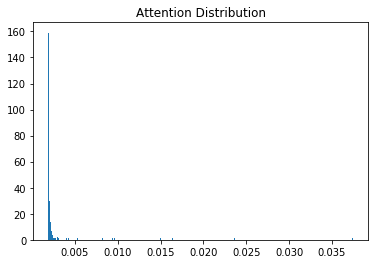

In [14]:
import matplotlib.pyplot as plt
plt.hist(attention, bins=1000)
plt.title('Attention Distribution')
plt.savefig('attention_ditribution', dpi=300)

In [21]:
sum(attention > 0.005)

19

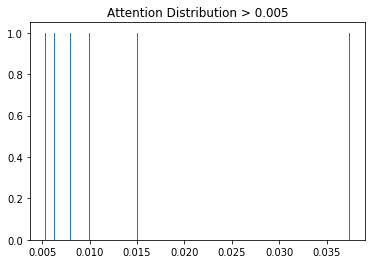

In [22]:
import matplotlib.pyplot as plt
plt.hist(attention[attention > 0.005], bins=1000)
plt.title('Attention Distribution > 0.005')
plt.savefig('attention_ditribution', dpi=300)

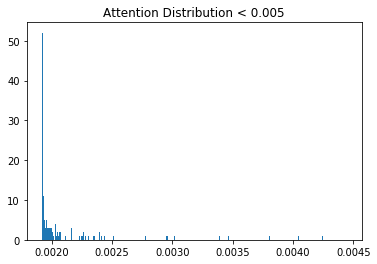

In [23]:
import matplotlib.pyplot as plt
plt.hist(attention[attention < 0.005], bins=1000)
plt.title('Attention Distribution < 0.005')
plt.savefig('attention_ditribution', dpi=300)

In [28]:
top_gene_idx = attention.argsort()[::-1][:50]

In [29]:
top_neighbor_genes = neighbor_genes[top_gene_idx]

In [30]:
top_neighbor_genes

array(['Cav2', 'Slc3a2', 'H2-Aa', 'Ptcra', 'Cldn15', 'Bmpr1a', 'Ccr9',
       'Cd44', 'Klra1', 'Ctla4', 'Akt3', 'Mif', 'Serpinc1', 'Lat', 'Irf9',
       'Cd5', 'Lgals1', 'Cd24a', 'Csf1', 'Gimap3', 'Pdcd1lg2', 'Zap70',
       'Gzmb', 'H2-DMa', 'Satb1', 'Stat6', 'Gzmf', 'Cxcl9', 'Icam1',
       'H2-Q6', 'Cd86', 'Cd3d', 'H2-T24', 'Srsf9', 'Echdc1', 'Irf8',
       'H2-D1', 'Itk', 'Zfp831', 'Clec1b', 'Ctsw', 'Lnx1', 'Il1b', 'Cd28',
       'Ece1', 'Cd2', 'Cd84', 'Cd19', 'Atp8a1', 'Il7r'], dtype=object)

### Calculate DREMI for all neighbor genes

In [63]:
neighbor_dremi = []
for gene in neighbor_genes:
    dremi = scprep.stats.knnDREMI(x=label_df[gene], y=label_df['Cd8a'])
    neighbor_dremi.append(dremi)
    
neighbor_dremi = np.array(neighbor_dremi)

/gpfs/ysm/project/amth/amth_av622/conda_envs/notebook_env/lib/python3.8/site-packages/scprep/stats.py:202: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  warnings.warn(
/gpfs/ysm/project/amth/amth_av622/conda_envs/notebook_env/lib/python3.8/site-packages/scprep/stats.py:202: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  warnings.warn(
/gpfs/ysm/project/amth/amth_av622/conda_envs/notebook_env/lib/python3.8/site-packages/scprep/stats.py:202: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  warnings.warn(
/gpfs/ysm/project/amth/amth_av622/conda_envs/notebook_env/lib/python3.8/site-packages/scprep/stats.py:202: UserWarning: Attempting to calculate kNN-DREMI on a constant array. Returning `0`
  warnings.warn(
/gpfs/ysm/project/amth/amth_av622/conda_envs/notebook_env/lib/python3.8/site-packages/scprep/stats.py:202: UserWarning: Attempting to calculate kNN-DREMI on a constant array. R

In [83]:
neighbor_dremi == 0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [65]:
# Cd8a doesn't count as a neighbor for this analysis
neighbor_dremi = neighbor_dremi[:-1]

In [66]:
neighbor_dremi.shape

(380,)

### DREMI score distribution

In [67]:
np.mean(neighbor_dremi)

1.2999205753205871

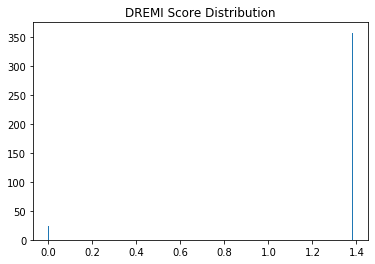

In [68]:
plt.hist(neighbor_dremi, bins=1000)
plt.title('DREMI Score Distribution')
plt.savefig('dremi_distribution', dpi=300)

### Ordering genes by highest to lowest attention, plot DREMI scores

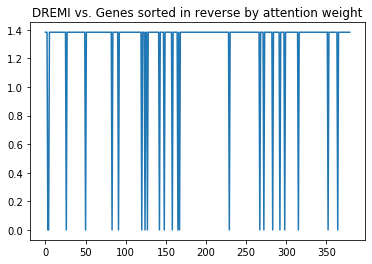

In [72]:
plt.plot(range(neighbor_dremi.shape[0]), neighbor_dremi[attention.argsort()[::-1]])
plt.title('DREMI vs. Genes sorted in reverse by attention weight')
plt.savefig('DREMI_vs_attention', dpi=300)

### Ordering genes by highest to lowest attention, plot DREMI scores for top 50 genes

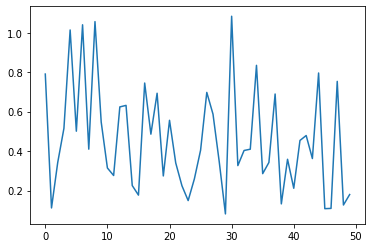

In [150]:
plt.plot(range(50), neighbor_dremi[attention.argsort()[::-1]][:50])

### Ordering genes by highest to lowest attention, plot cumulative mean DREMI score from first to all genes

In [73]:
top_dremi = []
for thresh in range(1,neighbor_dremi.shape[0]):
    top_dremi.append(np.mean(neighbor_dremi[attention.argsort()[::-1]][:thresh]))

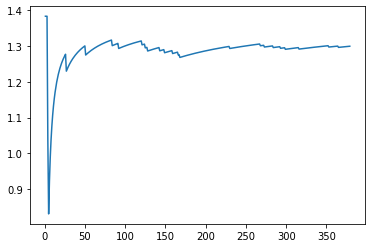

In [74]:
fig, axes = plt.subplots(1,1)
plt.plot(range(1,neighbor_dremi.shape[0]), top_dremi)

### Ordering genes randomly, plot cumulative mean DREMI score from first to all genes

In [199]:
import random

In [211]:
random_dremi = []
for r in range(10):
    r = []
    idx = list(range(neighbor_dremi.shape[0]))
    random.shuffle(idx)
    for thresh in range(1,neighbor_dremi.shape[0]):
        r.append(np.mean(neighbor_dremi[idx][:thresh]))
    random_dremi.append(r)

In [217]:
random_dremi = np.mean(np.array(random_dremi).reshape(10,neighbor_dremi.shape[0] - 1), axis=0)

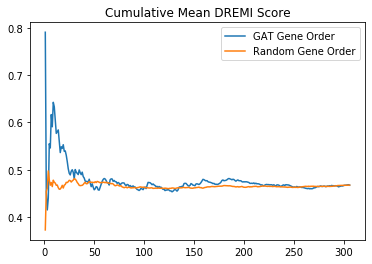

In [220]:
a, = plt.plot(range(1,neighbor_dremi.shape[0]), top_dremi)
b, = plt.plot(range(1,neighbor_dremi.shape[0]), random_dremi)
plt.title('Cumulative Mean DREMI Score')
plt.legend([a,b], ["GAT Gene Order", "Random Gene Order"])
plt.savefig('gene_order_mean', dpi=300)

## Visualization

In [81]:
phate_op = phate.PHATE()
count_df_phate = phate_op.fit_transform(label_df)

Calculating PHATE...
  Running PHATE on 979 observations and 18233 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.17 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.02 seconds.
    Calculating affinities...
  Calculated graph and diffusion operator in 1.28 seconds.
  Calculating optimal t...


/gpfs/ysm/project/amth/amth_av622/conda_envs/notebook_env/lib/python3.8/site-packages/graphtools/graphs.py:287: RuntimeWarning: Detected zero distance between 466 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Automatically selected t = 22
  Calculated optimal t in 0.24 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.17 seconds.
  Calculating metric MDS...
    Using SMACOF because SGD returned NaN
  Calculated metric MDS in 10.09 seconds.
Calculated PHATE in 11.78 seconds.


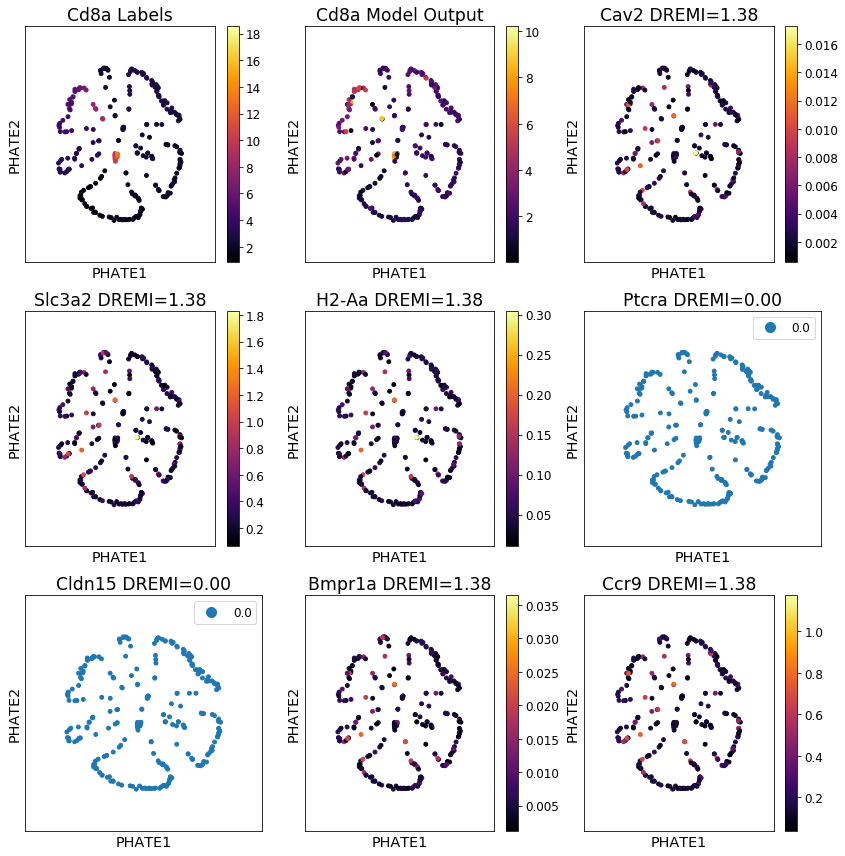

In [82]:
import scprep
fig, axes =plt.subplots(3,3, figsize=(12,12))
axes = axes.flatten()
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[0], s=15, c=labels_model.detach().numpy(),
                      title="Cd8a Labels",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[1], s=15, c=output_model.detach().numpy(),
                      title="Cd8a Model Output",ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[2], s=15, c=label_df[top_neighbor_genes[0]][idx_test],
                      title="{} DREMI={:.2f}".format(top_neighbor_genes[0], neighbor_dremi[top_gene_idx][0]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[3], s=15, c=label_df[top_neighbor_genes[1]][idx_test],
                      title="{} DREMI={:.2f}".format(top_neighbor_genes[1], neighbor_dremi[top_gene_idx][1]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[4], s=15, c=label_df[top_neighbor_genes[2]][idx_test],
                      title="{} DREMI={:.2f}".format(top_neighbor_genes[2], neighbor_dremi[top_gene_idx][2]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[5], s=15, c=label_df[top_neighbor_genes[3]][idx_test],
                      title="{} DREMI={:.2f}".format(top_neighbor_genes[3], neighbor_dremi[top_gene_idx][3]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[6], s=15, c=label_df[top_neighbor_genes[4]][idx_test],
                      title="{} DREMI={:.2f}".format(top_neighbor_genes[4], neighbor_dremi[top_gene_idx][4]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[7], s=15, c=label_df[top_neighbor_genes[5]][idx_test],
                      title="{} DREMI={:.2f}".format(top_neighbor_genes[5], neighbor_dremi[top_gene_idx][5]),ticks=False, label_prefix="PHATE")
scprep.plot.scatter2d(count_df_phate[idx_test], ax=axes[8], s=15, c=label_df[top_neighbor_genes[6]][idx_test],
                      title="{} DREMI={:.2f}".format(top_neighbor_genes[6], neighbor_dremi[top_gene_idx][6]),ticks=False, label_prefix="PHATE")
plt.tight_layout()

plt.savefig('top_attention_gene_vis', dpi=300)